In [1]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [2]:
dataset_filepath = 'weatherHistory.csv'
df = pd.read_csv(dataset_filepath)

univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']

In [3]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []
    
    window_size = input_size + offset
    
    if df_end_idx == None:
        df_end_idx = len(df) - window_size
    
    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size
        
        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx+window_size)]
        
        features.append(feature)
        labels.append(label)
    
    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)
    
    return features, labels

In [4]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size*dataset_length)
val_end_idx = int(val_size*dataset_length) + train_end_idx

X_train, y_train = slicing_window(
    univariate_df,
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_val, y_val = slicing_window(
    univariate_df,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_test, y_test = slicing_window(
    univariate_df,
    df_start_idx=val_end_idx,
    df_end_idx=None,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

In [5]:
class WeatherForecast(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        
        if self.transform:
            X = self.transform(X)
        
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        
        return X, y

In [6]:
train_dataset = WeatherForecast(X_train, y_train)
val_dataset = WeatherForecast(X_val, y_val)
test_dataset = WeatherForecast(X_test, y_test)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [10]:
class WeatherForcastor(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        super(WeatherForcastor, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [8]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    loss = sum(losses) / len(losses)
    acc = correct / total
    
    return correct, acc

def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            batch_train_losses.append(loss.item())
        
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)
        
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        print (f'EPOCH { epoch + 1}:\t Train loss :{train_loss:.4f}\t Val loss :{val_loss:.4f}')
    return train_losses, val_losses

In [11]:
embedding_dim = 1
hidden_dim = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForcastor(
    embedding_dim=embedding_dim,
    hidden_size=hidden_dim,
    n_layers=n_layers,
    dropout_prob=dropout_prob
)

lr = 1e-3
epochs = 50
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr
)

train_losses, val_losses = fit(
    model, train_loader, val_loader, criterion, optimizer, device, epochs
)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EPOCH 1:	 Train loss :135.5894	 Val loss :104.0000
EPOCH 2:	 Train loss :32.6198	 Val loss :104.0000
EPOCH 3:	 Train loss :15.5452	 Val loss :104.0000
EPOCH 4:	 Train loss :12.3172	 Val loss :104.0000
EPOCH 5:	 Train loss :10.9276	 Val loss :104.0000
EPOCH 6:	 Train loss :10.0757	 Val loss :104.0000
EPOCH 7:	 Train loss :9.8454	 Val loss :104.0000
EPOCH 8:	 Train loss :9.5660	 Val loss :104.0000
EPOCH 9:	 Train loss :9.3766	 Val loss :104.0000
EPOCH 10:	 Train loss :9.3429	 Val loss :104.0000
EPOCH 11:	 Train loss :8.9286	 Val loss :104.0000
EPOCH 12:	 Train loss :8.7623	 Val loss :104.0000
EPOCH 13:	 Train loss :8.6295	 Val loss :104.0000
EPOCH 14:	 Train loss :8.3187	 Val loss :104.0000
EPOCH 15:	 Train loss :8.2646	 Val loss :104.0000
EPOCH 16:	 Train loss :8.0518	 Val loss :104.0000
EPOCH 17:	 Train loss :7.8838	 Val loss :104.0000
EPOCH 18:	 Train loss :7.6924	 Val loss :104.0000
EPOCH 19:	 Train loss :7.6101	 Val loss :104.0000
EPOCH 20:	 Train loss :7.4843	 Val loss :104.0000
EP

In [12]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print('Evaluation on val / test dataset')
print('Val accuracy :', val_acc )
print('Test accuracy :', test_acc )

Evaluation on val / test dataset
Val accuracy : 0.005391394504924832
Test accuracy : 0.006639692914202718


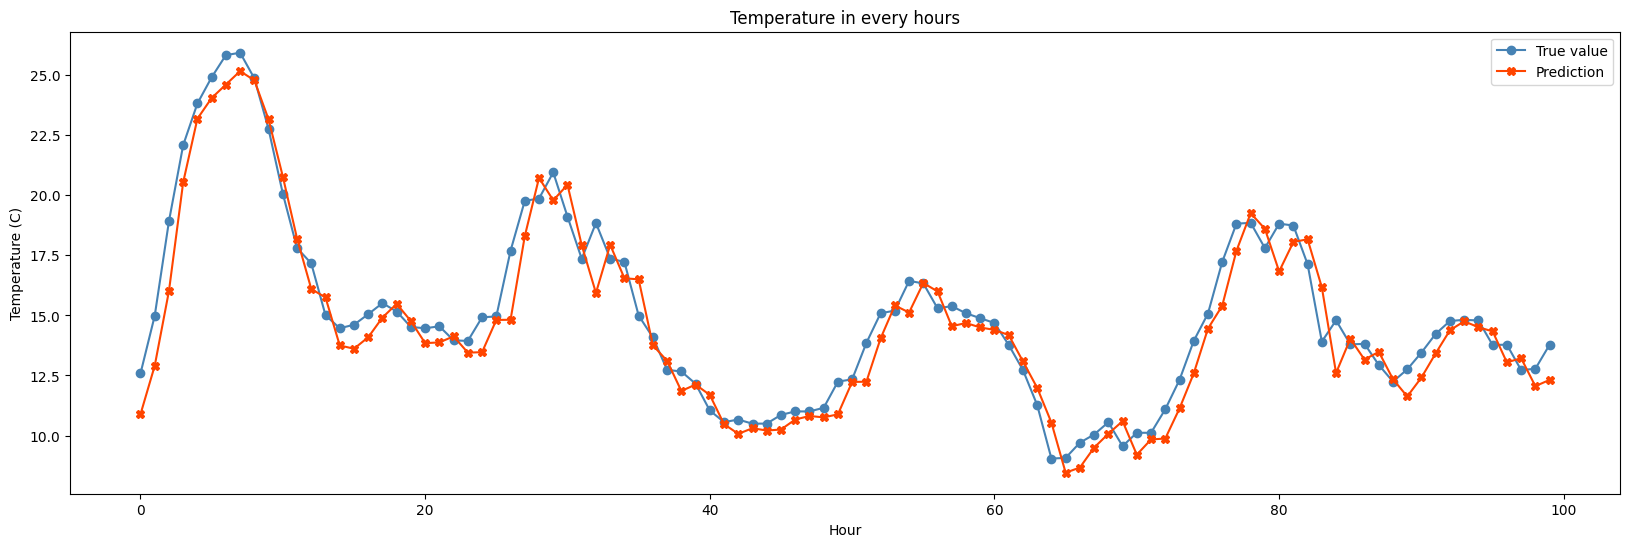

In [13]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()
    
    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')
    
    plt.title("Temperature in every hours")
    plt.xlabel("Hour")
    plt.ylabel("Temperature (C)")
    plt.legend()
    plt.show()
    
inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()
plot_difference(y_test[:100], outputs)